In [237]:
import yfinance as yf
import numpy as np
import pandas as pd
import pandas_datareader as reader
import matplotlib.pyplot as plt
import scipy.stats as stats
import talib
import datetime as dt
import statsmodels.api as sm

In [238]:
# The stock I choose is Bunge. Ticker "BG".
# Download yf data
data = yf.download("BG", start = '2013-09-01')

[*********************100%***********************]  1 of 1 completed


In [239]:
# Examine data
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-09-03,76.150002,76.860001,76.050003,76.309998,58.577438,594600
2013-09-04,76.250000,76.500000,75.510002,76.269997,58.546722,551300
2013-09-05,76.150002,76.650002,75.589996,76.589996,58.792377,427800
2013-09-06,76.650002,77.349998,76.400002,76.400002,58.646511,530200
2013-09-09,76.839996,77.260002,76.430000,77.070000,59.160824,441800
...,...,...,...,...,...,...
2023-09-07,110.839996,112.570000,110.709999,112.459999,112.459999,1345500
2023-09-08,112.680000,113.599998,112.029999,112.379997,112.379997,911100
2023-09-11,113.209999,115.180000,113.209999,114.870003,114.870003,1068300


In [240]:
# First do a simple FF5F model
# Examine available FF datasets
reader.famafrench.get_available_datasets()

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily',
 'Portfolios_Formed_on_ME',
 'Portfolios_Formed_on_ME_Wout_Div',
 'Portfolios_Formed_on_ME_Daily',
 'Portfolios_Formed_on_BE-ME',
 'Portfolios_Formed_on_BE-ME_Wout_Div',
 'Portfolios_Formed_on_BE-ME_Daily',
 'Portfolios_Formed_on_OP',
 'Portfolios_Formed_on_OP_Wout_Div',
 'Portfolios_Formed_on_OP_Daily',
 'Portfolios_Formed_on_INV',
 'Portfolios_Formed_on_INV_Wout_Div',
 'Portfolios_Formed_on_INV_Daily',
 '6_Portfolios_2x3',
 '6_Portfolios_2x3_Wout_Div',
 '6_Portfolios_2x3_weekly',
 '6_Portfolios_2x3_daily',
 '25_Portfolios_5x5',
 '25_Portfolios_5x5_Wout_Div',
 '25_Portfolios_5x5_Daily',
 '100_Portfolios_10x10',
 '100_Portfolios_10x10_Wout_Div',
 '100_Portfolios_10x10_Daily',
 '6_Portfolios_ME_OP_2x3',
 '6_Portfolios_ME_OP_2x3_Wout_Div',
 '6_Portfolios_ME_OP_2x3_daily',
 '25_Portfolios_ME_OP_5x5',
 '25_Portf

In [241]:
# Download the FF5F dataset
ff5f = reader.famafrench.FamaFrenchReader("F-F_Research_Data_5_Factors_2x3_daily", start = '2013-09-01', end = '2023-09-12').read()

/var/folders/7n/c2rtgbkj54zcwx4bwllz7tyh0000gn/T/ipykernel_97678/2279742324.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff5f = reader.famafrench.FamaFrenchReader("F-F_Research_Data_5_Factors_2x3_daily", start = '2013-09-01', end = '2023-09-12').read()


In [242]:
# Get the csv from the first column
ff5f_csv = ff5f[0]

In [243]:
# Examine the data
ff5f_csv

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2013-09-03,0.46,0.05,0.17,-0.49,-0.24,0.000
2013-09-04,0.83,0.00,-0.18,-0.11,0.07,0.000
2013-09-05,0.19,0.19,0.41,-0.19,-0.06,0.000
2013-09-06,0.00,-0.01,0.02,-0.17,-0.09,0.000
2013-09-09,1.09,0.43,-0.22,-0.19,-0.15,0.000
...,...,...,...,...,...,...
2023-07-25,0.25,-0.23,-0.79,0.47,-0.41,0.022
2023-07-26,0.02,0.87,1.03,-0.35,0.65,0.022
2023-07-27,-0.74,-0.80,0.27,0.38,0.14,0.022


In [244]:
# Define a function to run the multiple linear regression
def run_ff5f_regression(stock_returns, ff3f_data):
    # Merge stock returns with FF3F data
    merged_data = pd.merge(stock_returns, ff3f_data, on='Date')
    merged_data['Excess_Return'] = merged_data['Stock_Return'] - merged_data['RF']

    # Run regression
    X = merged_data[['Mkt-RF', 'SMB', 'HML', "RMW", "CMA"]]
    X = sm.add_constant(X)
    y = merged_data['Excess_Return']
    model = sm.OLS(y, X).fit()
    return model

In [245]:
# Modify original stock data
stock_returns = data['Adj Close'].pct_change().dropna()
stock_returns = stock_returns.reset_index()
stock_returns.columns = ['Date', 'Stock_Return']
# Get the multiple linear regression result
result_model = run_ff5f_regression(stock_returns, ff5f_csv)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [246]:
# Examine the result summary
print(result_model.summary)

<bound method RegressionResults.summary of <statsmodels.regression.linear_model.OLSResults object at 0x7fa572b378e0>>


In [247]:
# Make a simple decision
alpha = result_model.params['const']
print(alpha)
if alpha > 0:
    print("The stock is potentially overweight.")
else:
    print("The stock is potentially underweight.")

-0.0036328701458630823
The stock is potentially underweight.


In [248]:
# Based on the classic FF5F model, the stock is a bit underweight.
# Examine the data again
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-09-03,76.150002,76.860001,76.050003,76.309998,58.577438,594600
2013-09-04,76.250000,76.500000,75.510002,76.269997,58.546722,551300
2013-09-05,76.150002,76.650002,75.589996,76.589996,58.792377,427800
2013-09-06,76.650002,77.349998,76.400002,76.400002,58.646511,530200
2013-09-09,76.839996,77.260002,76.430000,77.070000,59.160824,441800
...,...,...,...,...,...,...
2023-09-07,110.839996,112.570000,110.709999,112.459999,112.459999,1345500
2023-09-08,112.680000,113.599998,112.029999,112.379997,112.379997,911100
2023-09-11,113.209999,115.180000,113.209999,114.870003,114.870003,1068300


In [249]:
# The next strategy I take is pure technical based.

In [250]:
# Calculate RSI (Relative Strength Index)
rsi = talib.RSI(data['Close'].values, timeperiod=14)
# Calculate MACD (Moving Average Convergence Divergence)
macd, macdsignal, macdhist = talib.MACD(data['Close'].values, fastperiod=12, slowperiod=26, signalperiod=9)
# Calculate Bollinger Bands
upper, middle, lower = talib.BBANDS(data['Close'].values, timeperiod=20)
# Create a DataFrame to store the technical indicators
indicators = pd.DataFrame({
    'Date': data.index,
    'Close': data['Close'],
    'RSI': rsi,
    'MACD': macd,
    'MACD Signal': macdsignal,
    'MACD Histogram': macdhist,
    'Bollinger Upper Band': upper,
    'Bollinger Middle Band': middle,
    'Bollinger Lower Band': lower
})
# Examine the last few rows of the indicators DataFrame
indicators.tail()

,Date,Close,RSI,MACD,MACD Signal,MACD Histogram,Bollinger Upper Band,Bollinger Middle Band,Bollinger Lower Band
Date,,,,,,,,,
2023-09-07,2023-09-07,112.459999,53.851257,1.296423,1.805769,-0.509347,114.917868,112.632499,110.347130
2023-09-08,2023-09-08,112.379997,53.533683,1.162723,1.677160,-0.514437,114.921904,112.644499,110.367094
2023-09-11,2023-09-11,114.870003,61.202634,1.243354,1.590399,-0.347045,115.240863,112.776499,110.312135
2023-09-12,2023-09-12,114.410004,59.256924,1.255663,1.523452,-0.267789,115.418385,112.852999,110.287613
2023-09-13,2023-09-13,113.150002,54.176307,1.150484,1.448858,-0.298374,115.432663,112.930499,110.428336


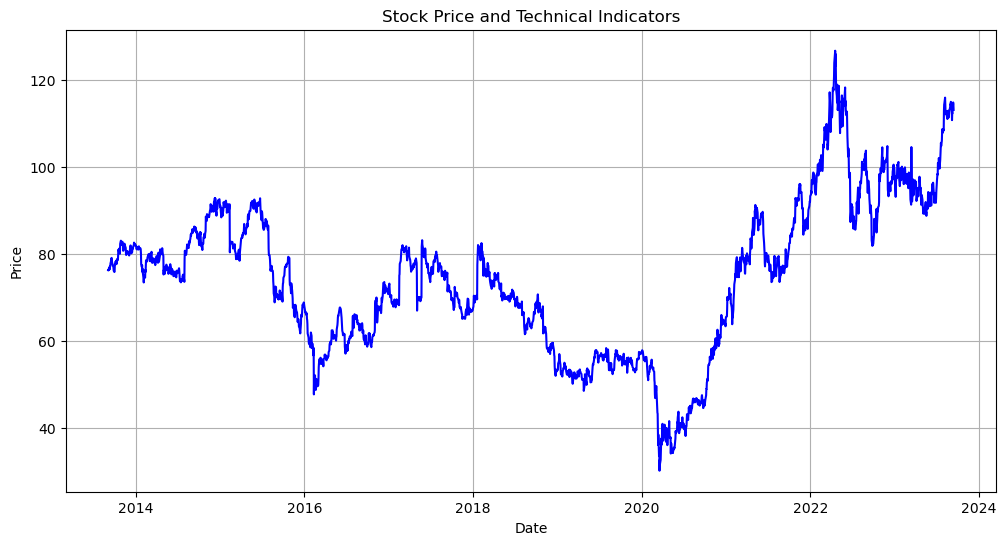

In [251]:
# Plot the stock price history
plt.figure(figsize=(12, 6))
plt.plot(indicators['Date'], indicators['Close'], label='Stock Price', color='blue')
plt.title('Stock Price and Technical Indicators')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)

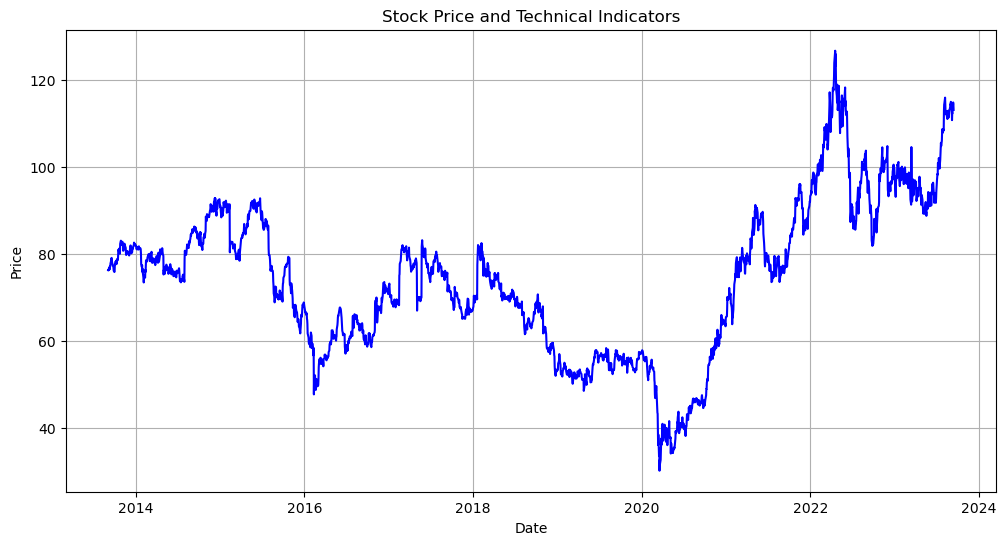

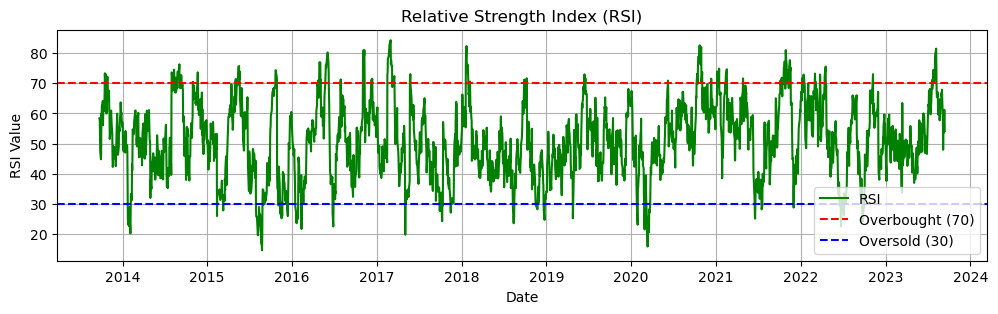

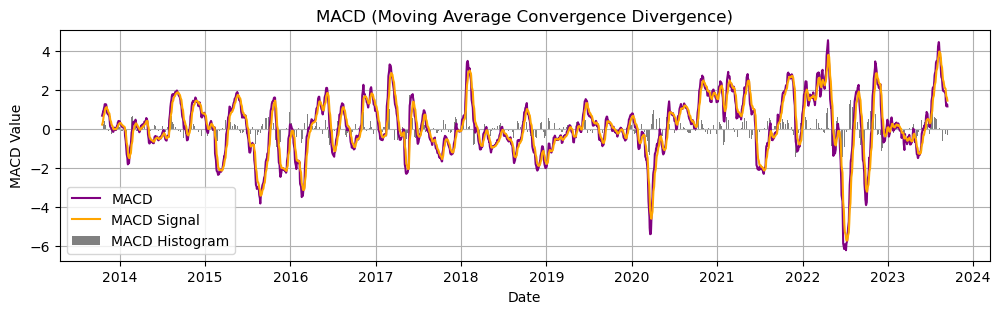

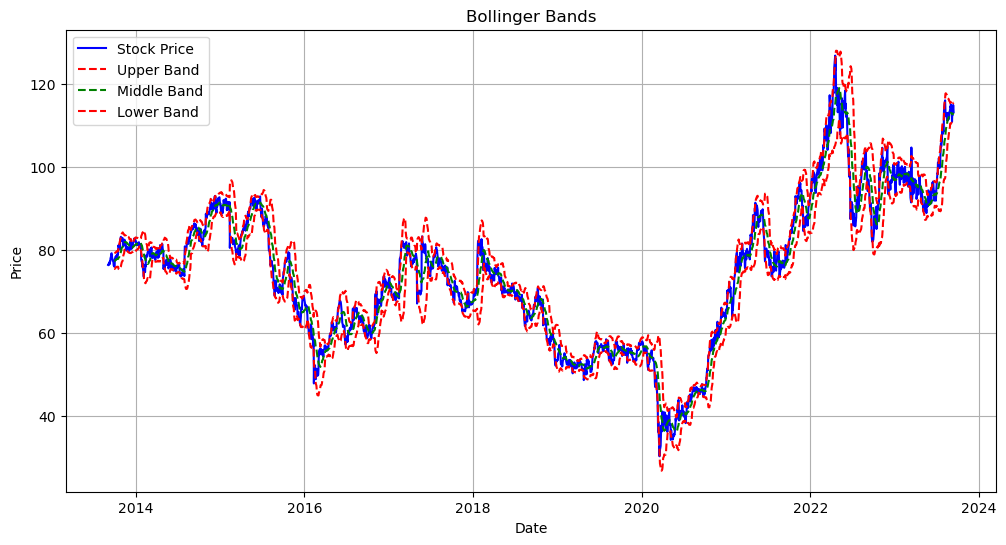

In [252]:
# Plot stock price history alongside with other indicators
plt.figure(figsize=(12, 6))
plt.plot(indicators['Date'], indicators['Close'], label='Stock Price', color='blue')
plt.title('Stock Price and Technical Indicators')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)

# Adding RSI
plt.figure(figsize=(12, 3))
plt.plot(indicators['Date'], indicators['RSI'], label='RSI', color='green')
plt.axhline(y=70, color='r', linestyle='--', label='Overbought (70)')
plt.axhline(y=30, color='b', linestyle='--', label='Oversold (30)')
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI Value')
plt.legend()
plt.grid(True)

# Adding MACD
plt.figure(figsize=(12, 3))
plt.plot(indicators['Date'], indicators['MACD'], label='MACD', color='purple')
plt.plot(indicators['Date'], indicators['MACD Signal'], label='MACD Signal', color='orange')
plt.bar(indicators['Date'], indicators['MACD Histogram'], label='MACD Histogram', color='grey')
plt.title('MACD (Moving Average Convergence Divergence)')
plt.xlabel('Date')
plt.ylabel('MACD Value')
plt.legend()
plt.grid(True)

# Adding Bollinger Bands
plt.figure(figsize=(12, 6))
plt.plot(indicators['Date'], indicators['Close'], label='Stock Price', color='blue')
plt.plot(indicators['Date'], indicators['Bollinger Upper Band'], label='Upper Band', color='red', linestyle='--')
plt.plot(indicators['Date'], indicators['Bollinger Middle Band'], label='Middle Band', color='green', linestyle='--')
plt.plot(indicators['Date'], indicators['Bollinger Lower Band'], label='Lower Band', color='red', linestyle='--')
plt.title('Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.show()

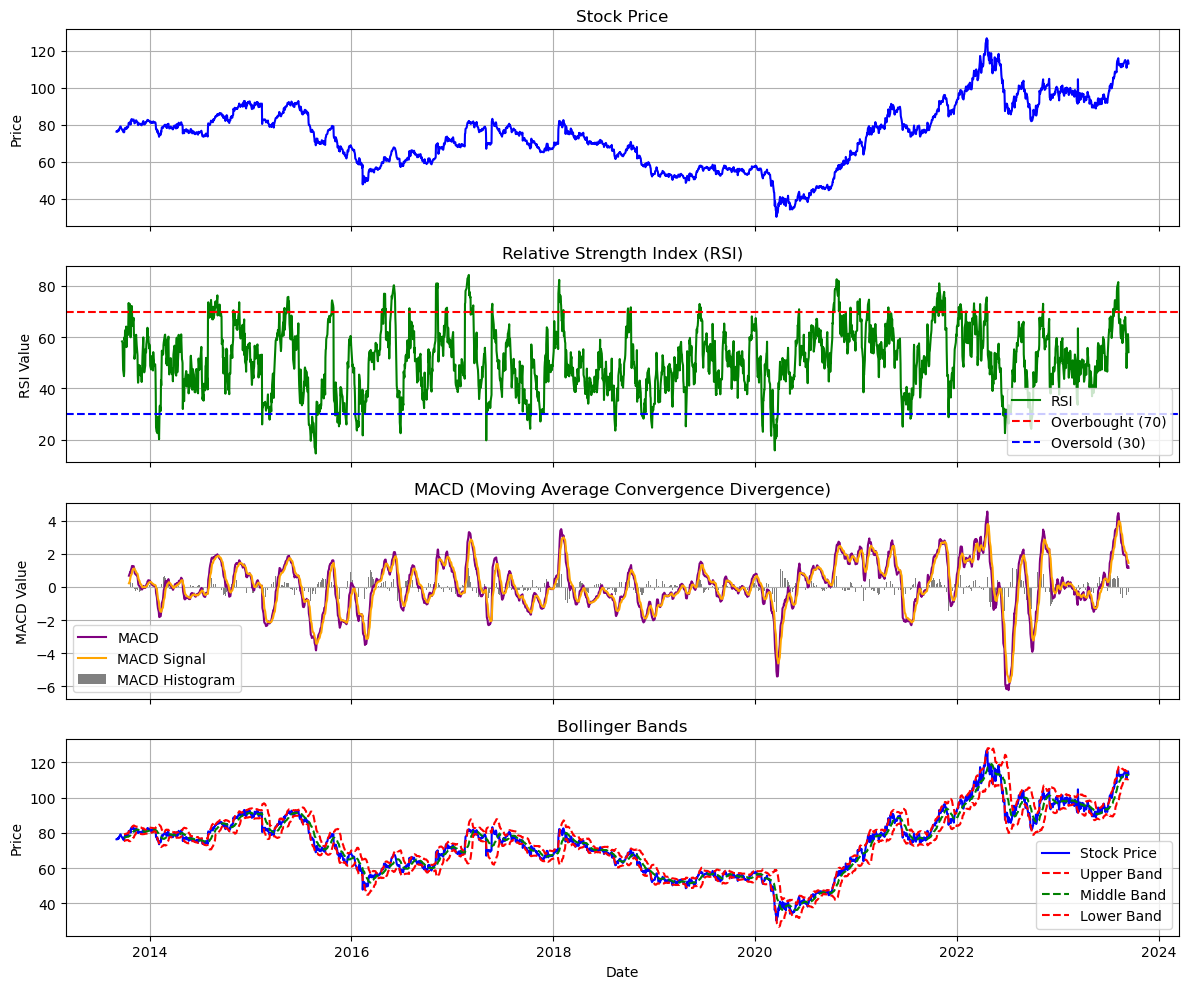

In [253]:
# Create a single figure with multiple subplots
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# Plotting on the first subplot
axes[0].plot(indicators['Date'], indicators['Close'], label='Stock Price', color='blue')
axes[0].set_title('Stock Price')
axes[0].set_ylabel('Price')
axes[0].grid(True)

# Adding RSI on the second subplot
axes[1].plot(indicators['Date'], indicators['RSI'], label='RSI', color='green')
axes[1].axhline(y=70, color='r', linestyle='--', label='Overbought (70)')
axes[1].axhline(y=30, color='b', linestyle='--', label='Oversold (30)')
axes[1].set_title('Relative Strength Index (RSI)')
axes[1].set_ylabel('RSI Value')
axes[1].legend()
axes[1].grid(True)

# Adding MACD on the third subplot
axes[2].plot(indicators['Date'], indicators['MACD'], label='MACD', color='purple')
axes[2].plot(indicators['Date'], indicators['MACD Signal'], label='MACD Signal', color='orange')
axes[2].bar(indicators['Date'], indicators['MACD Histogram'], label='MACD Histogram', color='grey')
axes[2].set_title('MACD (Moving Average Convergence Divergence)')
axes[2].set_ylabel('MACD Value')
axes[2].legend()
axes[2].grid(True)

# Adding Bollinger Bands on the fourth subplot
axes[3].plot(indicators['Date'], indicators['Close'], label='Stock Price', color='blue')
axes[3].plot(indicators['Date'], indicators['Bollinger Upper Band'], label='Upper Band', color='red', linestyle='--')
axes[3].plot(indicators['Date'], indicators['Bollinger Middle Band'], label='Middle Band', color='green', linestyle='--')
axes[3].plot(indicators['Date'], indicators['Bollinger Lower Band'], label='Lower Band', color='red', linestyle='--')
axes[3].set_title('Bollinger Bands')
axes[3].set_xlabel('Date')
axes[3].set_ylabel('Price')
axes[3].legend()
axes[3].grid(True)

# Adjust the layout for better spacing
plt.tight_layout()

# Show the combined figure with subplots
plt.savefig("10y plot.jpg")

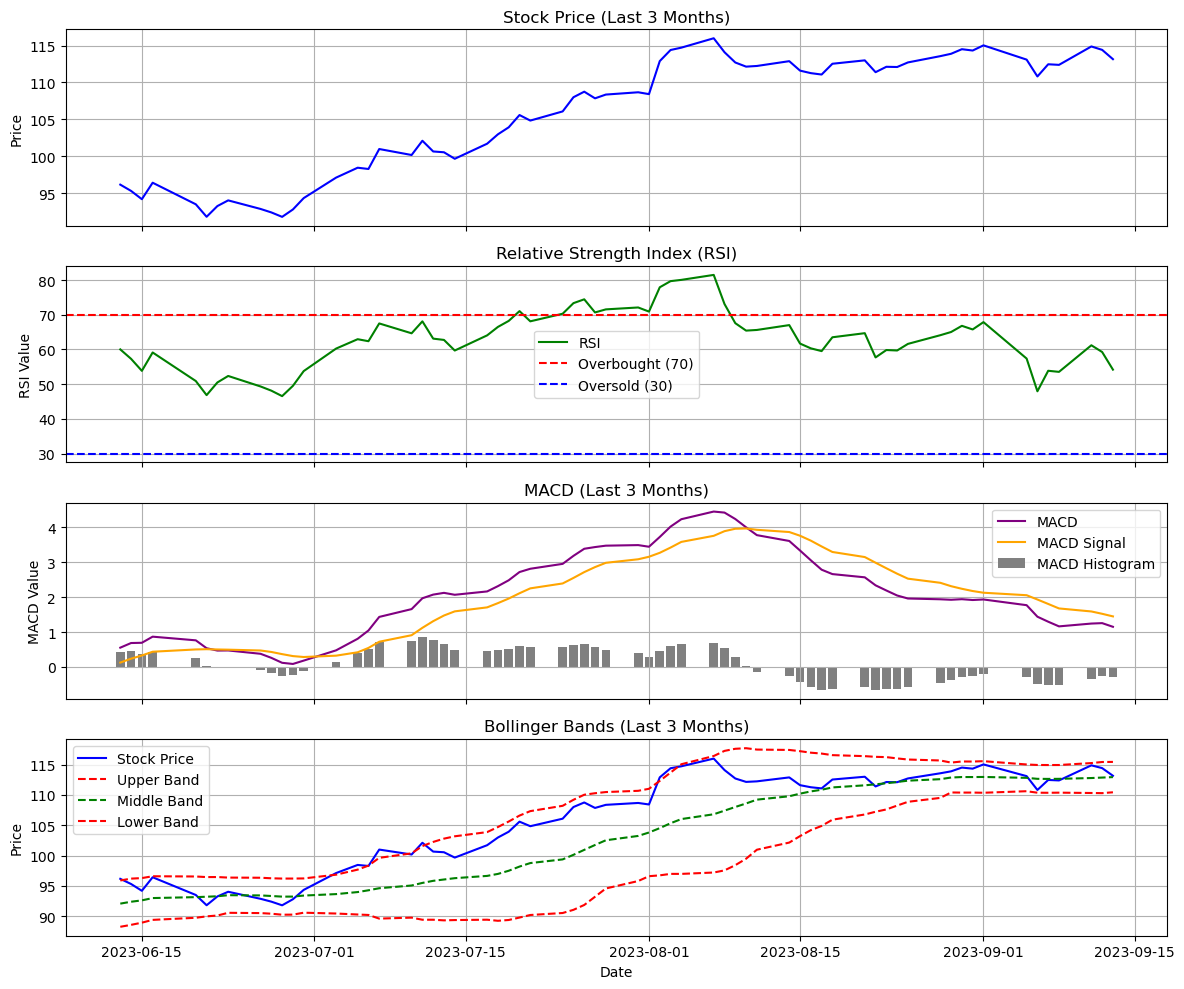

In [254]:
# Examine the past 3 months
# Define a date range for the last three months
end_date = dt.date.today()
start_date = (end_date - pd.DateOffset(months=3)).date()

# Convert the index to date objects using dt.date
# data.index = data.index.to_series().dt.date
# Slice data for the last three months
data3m = data.loc[(data.index.to_series().dt.date >= start_date) & (data.index.to_series().dt.date <= end_date)]

# Create a single figure with multiple subplots
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# Plotting on the first subplot
axes[0].plot(data3m.index, data3m['Close'], label='Stock Price', color='blue')
axes[0].set_title('Stock Price (Last 3 Months)')
axes[0].set_ylabel('Price')
axes[0].grid(True)

# Adding RSI on the second subplot
axes[1].plot(data3m.index, indicators.loc[indicators['Date'].isin(data3m.index.date)]['RSI'], label='RSI', color='green')
axes[1].axhline(y=70, color='r', linestyle='--', label='Overbought (70)')
axes[1].axhline(y=30, color='b', linestyle='--', label='Oversold (30)')
axes[1].set_title('Relative Strength Index (RSI)')
axes[1].set_ylabel('RSI Value')
axes[1].legend()
axes[1].grid(True)

# Adding MACD on the third subplot
axes[2].plot(data3m.index, indicators.loc[indicators['Date'].isin(data3m.index.date)]['MACD'], label='MACD', color='purple')
axes[2].plot(data3m.index, indicators.loc[indicators['Date'].isin(data3m.index.date)]['MACD Signal'], label='MACD Signal', color='orange')
axes[2].bar(data3m.index, indicators.loc[indicators['Date'].isin(data3m.index.date)]['MACD Histogram'], label='MACD Histogram', color='grey')
axes[2].set_title('MACD (Last 3 Months)')
axes[2].set_ylabel('MACD Value')
axes[2].legend()
axes[2].grid(True)

# Adding Bollinger Bands on the fourth subplot
axes[3].plot(data3m.index, data3m['Close'], label='Stock Price', color='blue')
axes[3].plot(data3m.index, indicators.loc[indicators['Date'].isin(data3m.index.date)]['Bollinger Upper Band'], label='Upper Band', color='red', linestyle='--')
axes[3].plot(data3m.index, indicators.loc[indicators['Date'].isin(data3m.index.date)]['Bollinger Middle Band'], label='Middle Band', color='green', linestyle='--')
axes[3].plot(data3m.index, indicators.loc[indicators['Date'].isin(data3m.index.date)]['Bollinger Lower Band'], label='Lower Band', color='red', linestyle='--')
axes[3].set_title('Bollinger Bands (Last 3 Months)')
axes[3].set_xlabel('Date')
axes[3].set_ylabel('Price')
axes[3].legend()
axes[3].grid(True)

# Adjust the layout for better spacing
plt.tight_layout()

# Show the combined figure with subplots
plt.savefig("3m plot.jpg")

In [255]:
# The technical analysis seems to show that the stock is traded at an acceptable level, and possibly a little bit overweight.

In [256]:
# We can also do some convensional financial analysis.
# BG is current having a trailing PE of 8.74, which is a bit lower than the industry average of 12. Thus, the company may be underweight.